### Importing Dependencies

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [20]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [21]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [22]:
processed_texts[:5]

["Psychosis inevitableMy psychosis inevitable fact subreddit typing post makes pathetic permanently damaged People things like depressed got help better bullshit People born Genetic Lottery birth given ticket winners live old age die happy losers cleaned road strive better position work work ass good college struck fucking lightning goes work dreams past present amp possible futures instant person gone going try tell life fucking gamble better thought better fucking giant ass band aid delayed inevitable realization fucking world fair warm fucking cold heartless wasteland humanity dies people grow cold evil world getting fucking darker darker evil permeating people shit like this](http://i.imgur.com/7dRqBp7.jpg posted today /r aww little glimmer hope little flower surviving fucking desolate wasteland appreciate fucking goddamn second shit like this](http://www.reddit.com r worldnews comments/1bkc2y brazilian_men_gangrape_an_american_girl_in_a/ posted worldnews realize want fucking bulle

In [23]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

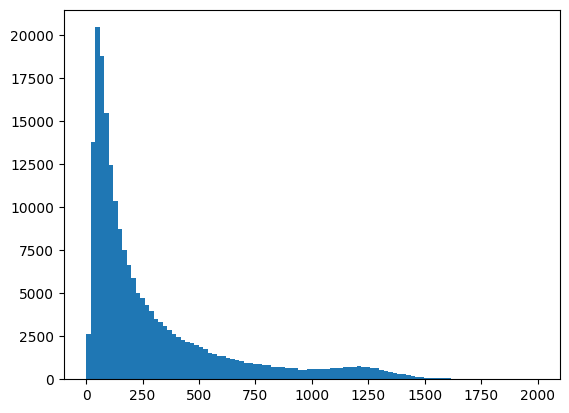

In [24]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [25]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [26]:
vectorized_texts = vectorize_layer(processed_texts)

In [27]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Model 1

In [28]:
from keras_tuner import HyperParameters as hp
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(3001, 16),
    keras.layers.SimpleRNN(5, return_sequences=True),
    keras.layers.SimpleRNN(5),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [29]:
model.fit(vectorized_texts, labels, epochs=10, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Epoch 1/10
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 117s 18ms/step - accuracy: 0.5074 - loss: 0.6976 - val_accuracy: 0.4989 - val_loss: 0.6917
Epoch 2/10
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 116s 18ms/step - accuracy: 0.5069 - loss: 0.6905 - val_accuracy: 0.5114 - val_loss: 0.6906
Epoch 3/10
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 116s 18ms/step - accuracy: 0.5044 - loss: 0.6898 - val_accuracy: 0.5097 - val_loss: 0.6911
Epoch 4/10
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 115s 18ms/step - accuracy: 0.5095 - loss: 0.6876 - val_accuracy: 0.4992 - val_loss: 0.6895
Epoch 5/10
6447/6447 ━━━━━━━━━━━━━━━━━━━━ 116s 18ms/step - accuracy: 0.5042 - loss: 0.6948 - val_accuracy: 0.4831 - val_loss: 0.6923


##### Evaluating the Model

In [30]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

#### Saving the Model

In [31]:
best_model = model
with open('../models/simple_rnn_none.pkl', 'wb') as fp:
    pickle.dump(model, fp)

In [32]:
best_model.summary()
_ = best_model.evaluate(vectorized_test_texts, test_labels)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 200, 5)         │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,563 (564.70 KB)

 Trainable params: 48,187 (188.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 96,376 (376.47 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4862 - loss: 0.6874


In [33]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.9891
False Negative Rate: 0.0289
accuracy_score 0.487
precision_score 0.491
recall_score 0.971
f1_score 0.652


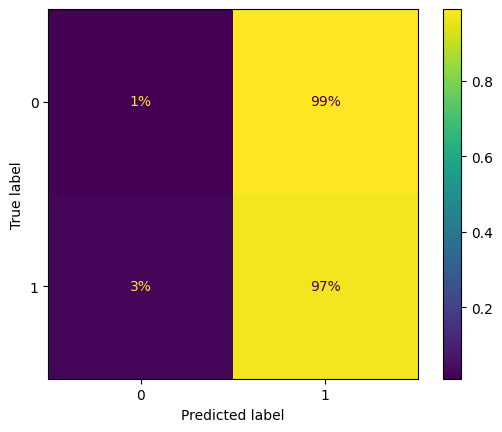

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()